# Hierachical Risk Parity Investment Strategy
## Use ETF of representative asset classes
#### Developed-Emerging Equity, Sector ,Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included
### Resuld is driven from 2012 to 2021 market data

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

In [5]:
import quantstats
from scipy.cluster.hierarchy import dendrogram, linkage

In [6]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/c/workspace/asset_allocation_strategy/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/c/workspace/asset_allocation_strategy
changed directory is :  /mnt/c/workspace/asset_allocation_strategy


In [7]:
start_date='2006-01-01'
end_date='2022-06-01'
cost=0.001

In [8]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

In [9]:
from benchmark_strategy.equal_weight import EqualWeightGenerator
from benchmark_strategy._60_40_allocation import _60_40_allocation
from benchmark_strategy._50_50_allocation import _50_50_allocation

[__init__] is executed in 4.26 seconds
[__init__] is executed in 3.66 seconds
[__init__] is executed in 3.88 seconds


### Load Data of each asset classes
##### Use representative ETF to model strategy
##### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [40]:
custom_universe =[
    "XAR",  # SPDR® S&P® Aerospace & Defense ETF                    2011-09-28
    "XLB",  # The Materials Select Sector SPDR® Fund                1998-12-16
    "XLE",  # The Energy Select Sector SPDR® Fund                   1998-12-22
    "XLF",  # The Financial Select Sector SPDR® Fund                1998-12-22
    "XLI",  # The Industrial Select Sector SPDR® Fund               1998-12-22
    "XLK",  # The Technology Select Sector SPDR® Fund               1998-12-22
    "XME",  # SPDR® S&P® Metals & Mining ETF                        2006-06-23
    "XLP",  # The Consumer Staples Select Sector SPDR® Fund         1998-12-22
    "XLY",  # The Consumer Discretionary Select Sector SPDR® Fund   1998-12-22
    "XLU",  # The Utilities Select Sector SPDR® Fund                1998-12-22
    "XLV",  # The Health Care Select Sector SPDR® Fund              1998-12-22
    "XPH",  # SPDR® S&P® Pharmaceuticals ETF                        2006-06-22
    "XBI",  # SPDR® S&P® Biotech ETF                                2006-02-06
    ]


In [41]:
class HierachicalRiskParity(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)
    
    def compute_target(self, universe_list):
        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        date = engine.date
        target_weight = {}
        target_weight =  self.compute_factor(date = date, tickers=universe_list)

        return target_weight
    
    def compute_factor(self, date, tickers):
        """
        to calculate r
        :param covariance_matrix: covariance matrix of assets in universe
        :return: [list] weight of risk parity investment strategy
        """
        date_3_month_lag = date - relativedelta(months=3)
        return_df = pd.DataFrame()
        for ticker in tickers:
            asset_series = self.cache['index'][ticker]['closeadj']
            asset_series.rename(ticker, inplace=True)
            return_df[ticker] = asset_series
        
        return_df = return_df.loc[date_3_month_lag : date]
        return_df =  return_df.pct_change().fillna(0)

        covariance_matrix = return_df.cov()
        correlation_matrix = return_df.corr()


        # distance matrix
        d_corr = (np.sqrt(0.5*(1-correlation_matrix))).fillna(0)
        link_corr = linkage(d_corr,'single')
        z = pd.DataFrame(link_corr)

        sort_index = self.get_quasi_diag(link_corr)
        weights = self.get_rec_bipart(cov=covariance_matrix, sort_ix=sort_index)
        weights.index = [return_df.columns[i] for i in weights.index]

        print(type(weights))
        print(weights)        
        target = {}
        for i in range(len(tickers)):
            target[tickers[i]] = weights.loc[tickers[i]]

        return target

    def get_quasi_diag(self, link):
        # sort clustered items by distance
        link = link.astype(int)

        # get the first and the second item of the last tuple
        sort_ix = pd.Series([link[-1,0], link[-1,1]])

        # the total num of items is the third item of the last list
        num_items = link[-1,3]

        # if the max of sort_ix is bigger than or equal to the max_items
        while sort_ix.max() >= num_items:
            sort_ix.index = range(0, sort_ix.shape[0]*2, 2) # make space
            df0 = sort_ix[sort_ix >= num_items] # find clusters

            # df0 contains even index and cluster index
            i = df0.index
            j = df0.values - num_items
            sort_ix[i] = link[j,0] # item 1

            df0  = pd.Series(link[j, 1], index=i+1)
            sort_ix = sort_ix.append(df0) # item 2
            sort_ix = sort_ix.sort_index()
            sort_ix.index = range(sort_ix.shape[0])
        return sort_ix.tolist()

    def get_cluster_var(self, cov, c_items):
        cov_ = cov.iloc[c_items, c_items] # matrix slice
        # calculate the inverse-variance portfolio
        ivp = 1./np.diag(cov_)
        ivp/=ivp.sum()
        w_ = ivp.reshape(-1,1)
        c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0]
        return c_var

    def get_rec_bipart(self, cov, sort_ix):
        # compute HRP allocation
        # intialize weights of 1
        w = pd.Series(1, index=sort_ix)

        # intialize all items in one cluster
        c_items = [sort_ix]
        while len(c_items) > 0:
            # bisection
            c_items = [i[int(j):int(k)] for i in c_items for j,k in
                    ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]

            # parse in pairs
            for i in range(0, len(c_items), 2):

                c_items0 = c_items[i] # cluster 1
                c_items1 = c_items[i+1] # cluter 2

                c_var0 = self.get_cluster_var(cov, c_items0)
                c_var1 = self.get_cluster_var(cov, c_items1)

                alpha = 1 - c_var0/(c_var0+c_var1)

                w[c_items0] *= alpha
                w[c_items1] *=1-alpha

        return w


In [42]:
engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
rp = HierachicalRiskParity(engine.cache)
engine.run_backtest(target_generator=rp, sdate=start_date, edate=end_date, transaction_cost=cost)
my_strategy = engine.asset_df.sum(axis=1)

[__init__] is executed in 11.62 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
<class 'pandas.core.series.Series'>
XLV    0.179261
XLB    0.106222
XLP    0.198291
XLF    0.060321
XLK    0.080184
XLI    0.120588
SPY    0.124975
XLY    0.086570
XLE    0.010645
XLU    0.032944
dtype: float64
<class 'pandas.core.series.Series'>l_asset:1.004 / time elapsed:0.8 ===
XLB    0.070775
XLF    0.090498
XLK    0.076441
SPY    0.079240
XLY    0.052455
XLI    0.132808
XLP    0.211499
XLV    0.183632
XLE    0.019647
XLU    0.083005
dtype: float64
<class 'pandas.core.series.Series'>l_asset:1.013 / time elapsed:0.8 ===
XBI    0.140350
XLB    0.079897
XLP    0.171780
XLV    0.075329
XLF    0.058357
XLK    0.064945
SPY    0.073244
XLY    0.076484
XLI    0.148384
XLE    0.018562
XLU    0.092668
dtype: float64
<class 'pandas.core.series.Series'>l_asset:1.014 / time elapsed:0.9 ===
XBI    0.082252
XLB    0.068731
XLF    0.118769
XLY    0.084267
XLI    0.069206
XLK    0.072675
SPY    0.10

## Compare this strategy with 1/N portfolio

In [43]:
bm_engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
equal = EqualWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=equal, sdate=start_date, edate=end_date, transaction_cost=cost)
bm_strategy = bm_engine.asset_df.sum(axis=1)

[__init__] is executed in 10.35 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:4.543 / time elapsed:10.9 ===
[run_backtest] is executed in 11.11 seconds


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-06-01  2022-06-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          362.56%     354.74%
CAGR﹪                     9.78%       9.66%

Sharpe                     0.63        0.56
Prob. Sharpe Ratio         99.41%      98.78%
Smart Sharpe               0.57        0.51
Sortino                    0.87        0.78
Smart Sortino              0.79        0.7
Sortino/√2                 0.62        0.55
Smart Sortino/√2           0.56        0.5
Omega                      1.13        1.13

Max Drawdown               -45.46%     -50.77%
Longest DD Days            1130        1119
Volatility (ann.)          17.21%      20.1%
R^2                        0.96        0.96
Information Ratio          -0.01       -0.01
Calmar                     0.22        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-12-11,2009-03-09,2011-01-14,1130,-45.455786,-41.510608
2,2020-02-18,2020-03-23,2020-09-02,197,-35.032966,-30.171268
3,2018-09-24,2018-12-24,2019-06-19,268,-17.937312,-14.929311
4,2011-07-08,2011-08-08,2012-02-01,208,-15.637287,-14.959936
5,2015-05-22,2016-01-20,2016-06-06,381,-13.741927,-13.258063


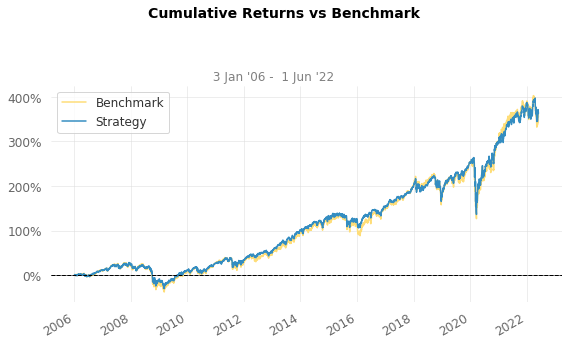

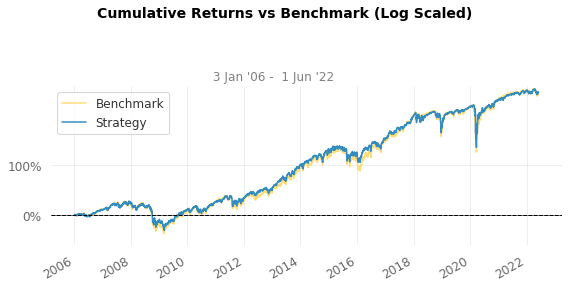

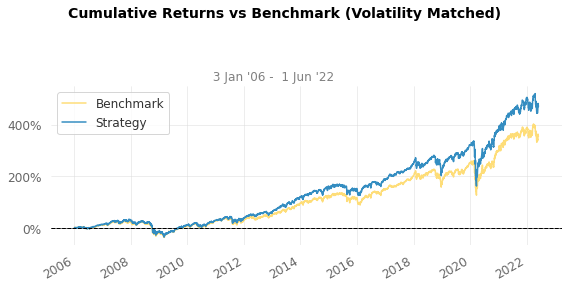

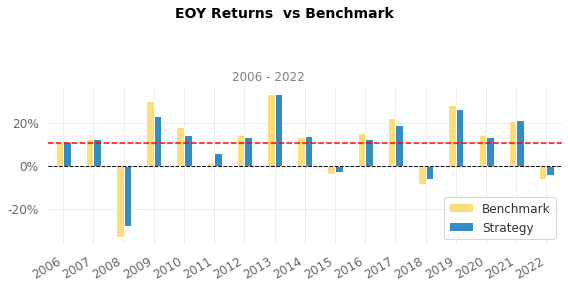

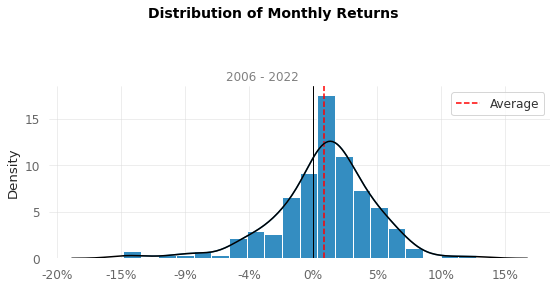

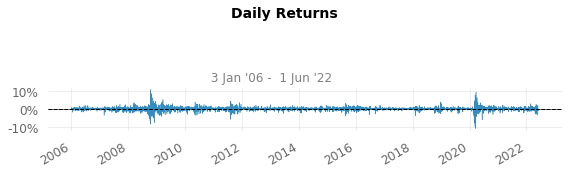

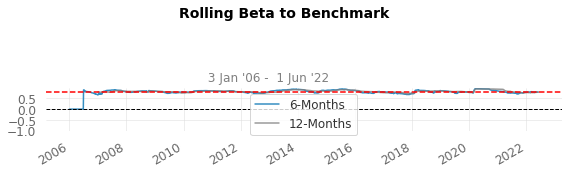

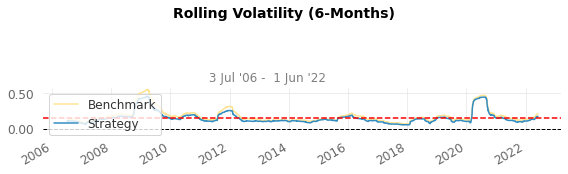

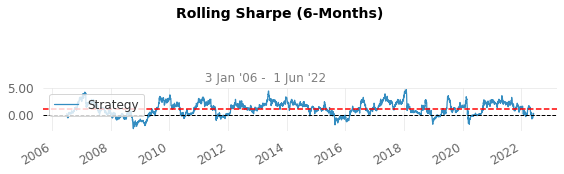

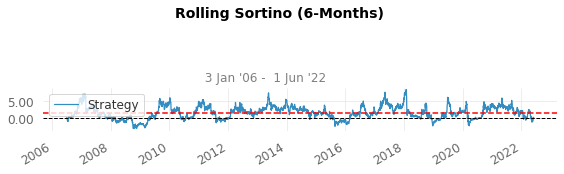

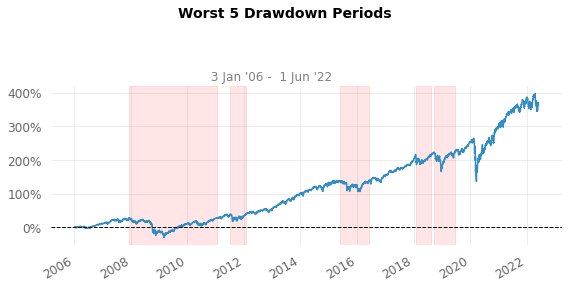

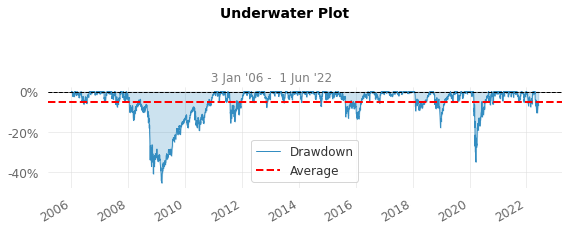

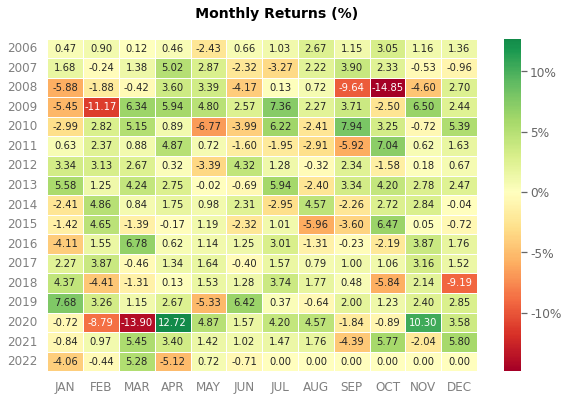

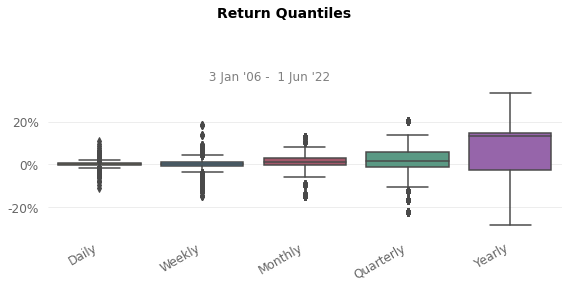

In [44]:
quantstats.reports.full(returns=my_strategy, benchmark=bm_strategy)

In [45]:
historical_portfolio = engine.asset_df
weight_historical_portfolio = pd.DataFrame(index=historical_portfolio.index, columns=historical_portfolio.columns)
for date in historical_portfolio.index:
    for ticker in historical_portfolio.columns:
        weight_historical_portfolio.loc[date,ticker] = historical_portfolio.loc[date,ticker]/historical_portfolio.loc[date].sum(axis=0)
weight_historical_portfolio

,cash,XLP,XLF,XLB,XLK,SPY,XLV,XLE,XLU,XLY,XLI,XBI,XPH,XME,XAR
2006-01-03,0.0,0.198291,0.060321,0.106222,0.080184,0.124975,0.179261,0.010645,0.032944,0.08657,0.120588,0.0,0.0,0.0,0.0
2006-01-04,0.0,0.197966,0.059961,0.106336,0.080716,0.124935,0.180136,0.010622,0.03283,0.086212,0.120285,0.0,0.0,0.0,0.0
2006-01-05,0.0,0.197238,0.060252,0.106317,0.081206,0.125192,0.179949,0.010502,0.032661,0.086414,0.120267,0.0,0.0,0.0,0.0
2006-01-06,0.0,0.196591,0.060151,0.106639,0.081861,0.125285,0.179755,0.010679,0.032762,0.086464,0.119815,0.0,0.0,0.0,0.0
2006-01-09,0.0,0.196703,0.060071,0.106168,0.081785,0.125092,0.179844,0.010623,0.032425,0.086989,0.1203,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-25,0.0,0.145369,0.046294,0.094156,0.034149,0.06906,0.075203,0.054054,0.217152,0.02178,0.076826,0.019099,0.067343,0.028737,0.050778
2022-05-26,0.0,0.144935,0.046726,0.094594,0.034498,0.069491,0.074507,0.053915,0.214835,0.02254,0.077329,0.019047,0.067196,0.029305,0.051082
2022-05-27,0.0,0.14382,0.046608,0.094964,0.034985,0.069839,0.0743,0.053854,0.214031,0.022869,0.077411,0.019399,0.067215,0.029256,0.051448
2022-05-31,0.0,0.14443,0.047006,0.094583,0.035131,0.070237,0.074142,0.053649,0.213481,0.023247,0.077661,0.018982,0.067419,0.028546,0.051487


<AxesSubplot:>

<Figure size 864x576 with 0 Axes>

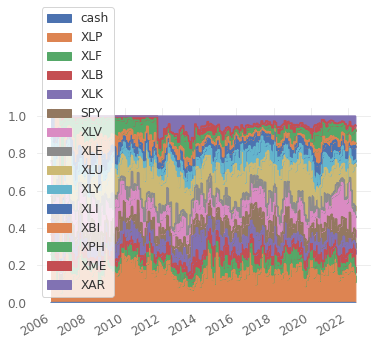

In [46]:
plt.figure(figsize=(12,8))
weight_historical_portfolio.plot.area()

## Compare this strategy with S&P500 index

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-06-01  2022-06-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          362.56%     344.35%
CAGR﹪                     9.78%       9.51%

Sharpe                     0.63        0.56
Prob. Sharpe Ratio         99.41%      98.78%
Smart Sharpe               0.57        0.5
Sortino                    0.87        0.78
Smart Sortino              0.79        0.71
Sortino/√2                 0.62        0.55
Smart Sortino/√2           0.56        0.5
Omega                      1.13        1.13

Max Drawdown               -45.46%     -55.19%
Longest DD Days            1130        1772
Volatility (ann.)          17.21%      19.84%
R^2                        0.93        0.93
Information Ratio          -0.0        -0.0
Calmar                     0.22        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-12-11,2009-03-09,2011-01-14,1130,-45.455786,-41.510608
2,2020-02-18,2020-03-23,2020-09-02,197,-35.032966,-30.171268
3,2018-09-24,2018-12-24,2019-06-19,268,-17.937312,-14.929311
4,2011-07-08,2011-08-08,2012-02-01,208,-15.637287,-14.959936
5,2015-05-22,2016-01-20,2016-06-06,381,-13.741927,-13.258063


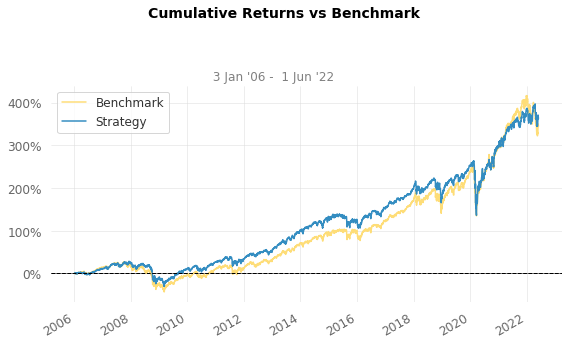

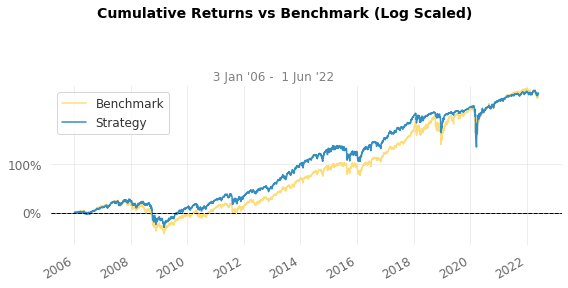

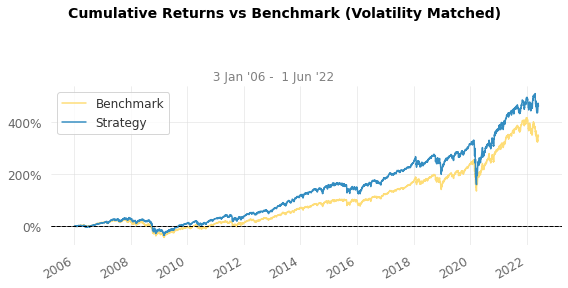

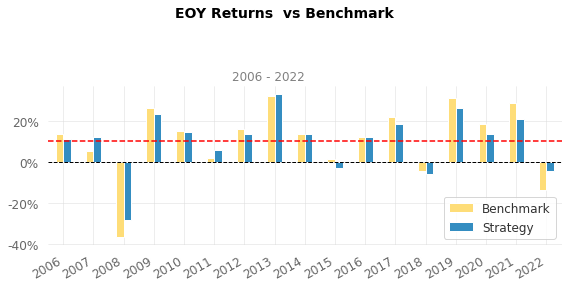

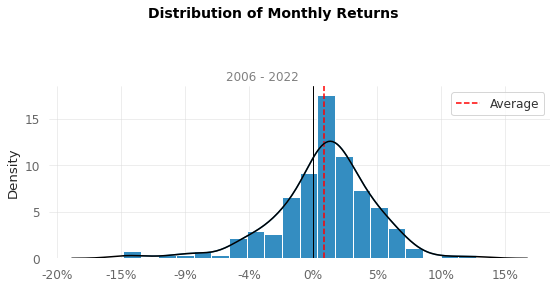

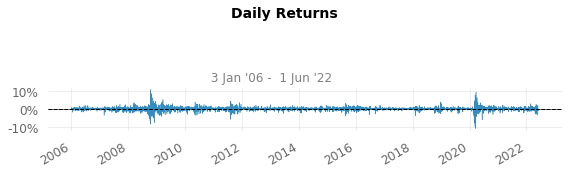

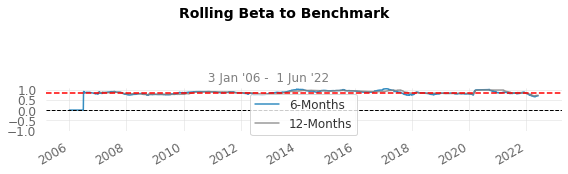

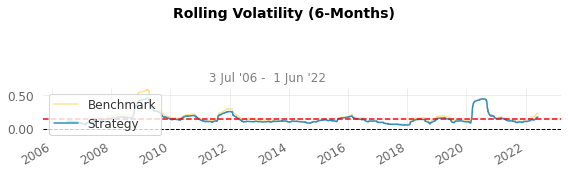

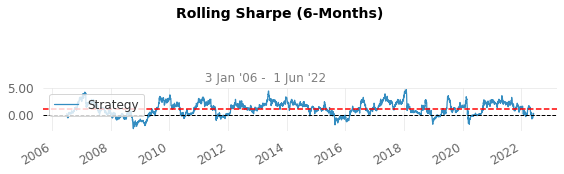

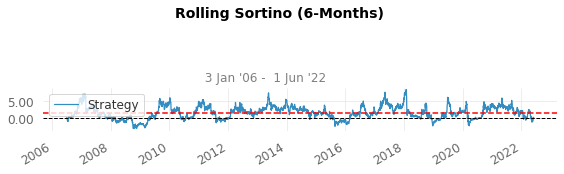

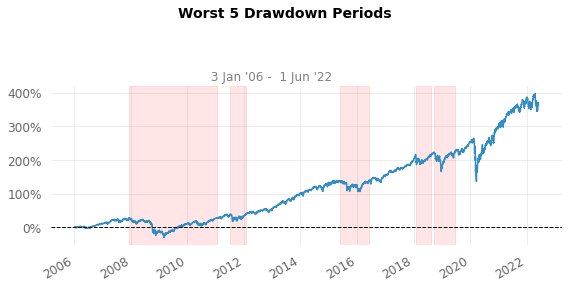

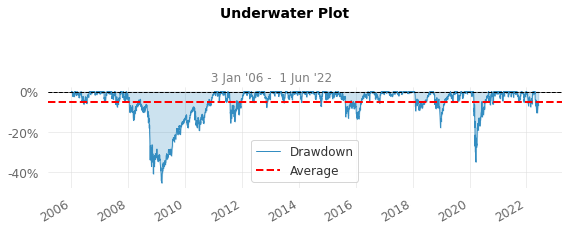

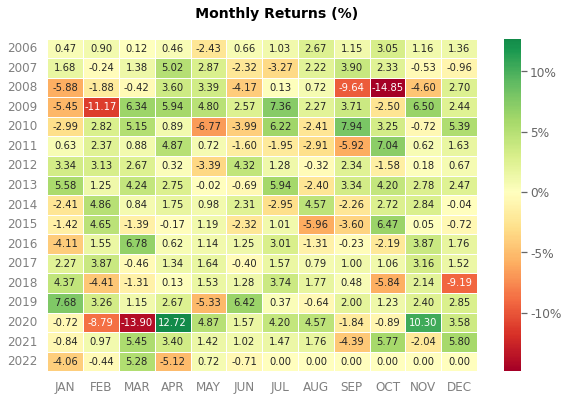

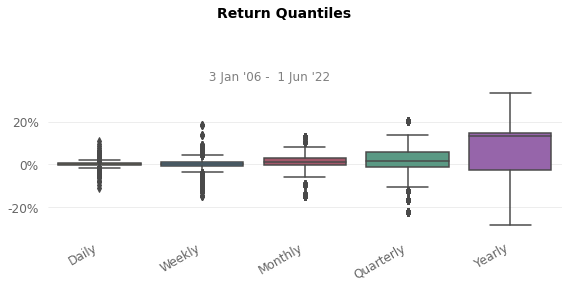

In [47]:
quantstats.reports.full(returns=my_strategy, benchmark="SPY")